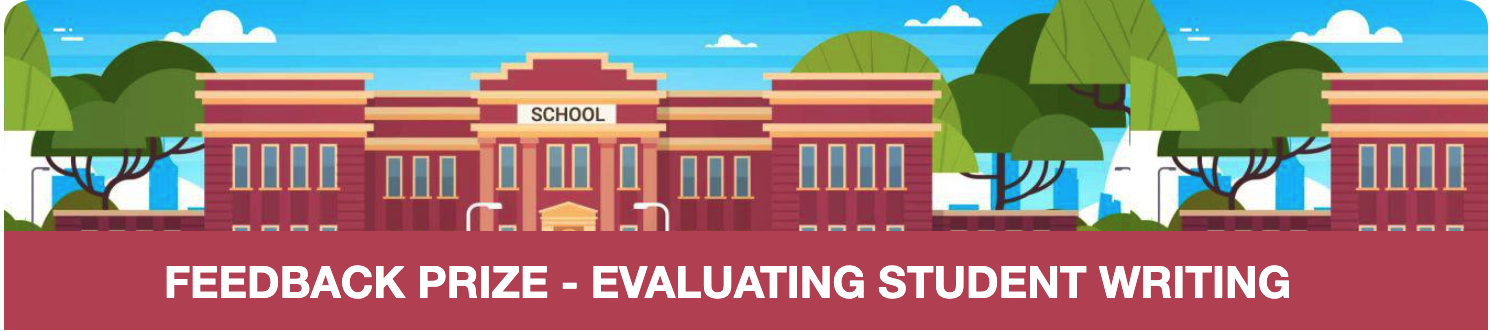

<b>Competition URL</b>:
https://www.kaggle.com/c/feedback-prize-2021/overview

<b style='background-color:#fbffb3'>I will try to keep this notebook updated as much as possible</b>

## Table of Contents
* [Dataset Information](#data_information)
    - [Data description](#data_description)
    - [Files](#files)
* [Preliminary Data Exploration](#preliminary_eda)
    - [Install and Import Libraries](#install_and_import_libraries)
    - [Load Data](#load_data)
    - [General Dataset Information](#general_dataset_information)
* [Exploratory Data Analysis](#eda)
    - [Text Length](#text_length)
    - [Word Count](#word_count)
    - [Distribution of top n-grams](#distribution_of_top_n_grams)
    - [Distribution of top n-grams for each discourse type](#distribution_of_top_n_grams_for_each_discourse_type)
    - [Text Distribution](#text_distribution)
    - [Word Clouds](#word_clouds)
    - [Displaying Labels](#displaying_labels)
    - [NER: Name Entity Recognition](#ner)
    - [Text Clustering](#text_clustering)
    - [Word Embeddings Visualization](#w2vec)

<a id='data_information'></a>
# Dataset Information

<a id='data_description'></a>
## Data Description

<div>The dataset contains argumentative essays written by U.S students in grades 6-12. The essays were annotated by expert raters for elements commonly found in argumentative writing.</br>
The task is to predict the human annotations. You will first need to segment each essay into discrete rhetorical and argumentative elements (i.e., discourse elements) and then classify each element as one of the following:

<span style="background-color:#e1e6e3;">Lead</span> - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis</br>
<span style="background-color:#e1e6e3;">Position</span> - an opinion or conclusion on the main question</br>
<span style="background-color:#e1e6e3;">Claim</span> - a claim that supports the position</br>
<span style="background-color:#e1e6e3;">Counterclaim</span> - a claim that refutes another claim or gives an opposing reason to the position</br>
<span style="background-color:#e1e6e3;">Rebuttal</span> - a claim that refutes a counterclaim</br>
<span style="background-color:#e1e6e3;">Evidence</span> - ideas or examples that support claims, counterclaims, or rebuttals.</br>
<span style="background-color:#e1e6e3;">Concluding Statement</span> - a concluding statement that restates the claims</br>
</br>
<b>Important</b>:
Note that some parts of the essays will be unannotated (i.e., they do not fit into one of the classifications above).

<a id='files'></a>
<h3>Files</h3>
<span style="background-color:#e1e6e3;">train.zip</span> - folder of individual .txt files, with each file containing the full text of an essay response in the training set </br>
<span style="background-color:#e1e6e3;">train.csv</span> - file containing the annotated version of all essays in the training set </br>
<span style="background-color:#e1e6e3;">test.zip</span> - folder of individual .txt files, with each file containing the full text of an essay response in the test set </br>
<span style="background-color:#e1e6e3;">sample_submission.csv</span> - file in the required format for making predictions - note that if you are making multiple predictions for a document, submit multiple rows </br></div>

<a id='preliminary_eda'></a>
# Preliminary Data Exploration

<a id='install_and_import_libraries'></a>
## Install and Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.decomposition import PCA

from nltk.stem.snowball import SnowballStemmer

plt.style.use('ggplot')

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

<a id='load_data'></a>
## Load Data

In [ ]:
df = pd.read_csv('../input/feedback-prize-2021/train.csv')
print(f'The training set has {df.shape[0]} rows and {df.shape[1]} columns')

<a id='general_dataset_information'></a>
## General Dataset Information

In [ ]:
df.info()

In [ ]:
df.head()

The column descriptions are:
- <span style="background-color:#e1e6e3;">id</span> - ID code for essay response
- <span style="background-color:#e1e6e3;">discourse_id</span> - ID code for discourse element
- <span style="background-color:#e1e6e3;">discourse_start</span> - character position where discourse element begins in the essay response
- <span style="background-color:#e1e6e3;">discourse_end</span> - character position where discourse element ends in the essay response
- <span style="background-color:#e1e6e3;">discourse_text</span> - text of discourse element
- <span style="background-color:#e1e6e3;">discourse_type</span> - classification of discourse element
- <span style="background-color:#e1e6e3;">discourse_type_num</span> - enumerated class label of discourse element
- <span style="background-color:#e1e6e3;">predictionstring</span> - the word indices of the training sample, as required for predictions

In [ ]:
print(f"We have {df['id'].nunique()} essays")

<a id='eda'></a>
# Exploratory Data Analysis

In [ ]:
df['full_text'] = df['discourse_text'].groupby(df['id']).transform(lambda x: ' '.join(x)) # obviously we will have duplicates

Let's see for example the first essay:

In [ ]:
df.full_text.iloc[0]

Let's see the length distribution of all essay:

<a id='text_length'></a>
## Text Length

In [ ]:
text_length = df['full_text'].drop_duplicates().apply(len)

fig = plt.figure(figsize=(10,8))

ax1 = text_length.plot(kind='hist', color = "#120f7a", bins=100)
ax1.set_title('Essay Length Distribution')
ax1.set_xlabel("Essay Length")
ax1.set_ylabel("Frequency")

plt.show()

And word count distribution:

<a id='word_count'></a>
## Word Count

In [ ]:
word_count = df['full_text'].drop_duplicates().apply(lambda x: len(str(x).split()))

fig = plt.figure(figsize=(10,8))

ax1 = word_count.plot(kind='hist', color = "#120f7a", bins=100)
ax1.set_title('Word Count Distribution')
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Frequency")

plt.show()

<a id='distribution_of_top_n_grams'></a>
## Distribution of top n-grams for full-text essays

In [ ]:
def get_top_n_words(corpus, n=None, remove_stop_words=False, n_words=1): # if n_words=1 -> unigrams, if n_words=2 -> bigrams..
    if remove_stop_words:
        vec = CountVectorizer(stop_words = 'english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#### Unigrams

In [ ]:
common_words = get_top_n_words(df['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=1)
for word, freq in common_words:
    print(word, freq)

In [ ]:
df_tmp = pd.DataFrame(common_words, columns = ['text' , 'count'])

fig = plt.figure(figsize=(10,8))

ax1 = df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

plt.show()

#### Bigrams

In [ ]:
common_words = get_top_n_words(df['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

In [ ]:
df_tmp = pd.DataFrame(common_words, columns = ['text' , 'count'])

fig = plt.figure(figsize=(10,8))

ax1 = df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

plt.show()

#### Trigrams

In [ ]:
common_words = get_top_n_words(df['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

In [ ]:
df_tmp = pd.DataFrame(common_words, columns = ['text' , 'count'])

fig = plt.figure(figsize=(10,8))

ax1 = df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Trigram Distribution')
ax1.set_xlabel("Trigrams")
ax1.set_ylabel("Frequency")

plt.show()

<a id='distribution_of_top_n_grams_for_each_discourse_type'></a>
## Distribution of top n-grams for each discourse type

#### Unigrams

In [ ]:
text_Lead = df[df.discourse_type == 'Lead'].discourse_text.values
text_Position = df[df.discourse_type == 'Position'].discourse_text.values
text_Evidence = df[df.discourse_type == 'Evidence'].discourse_text.values
text_Claim = df[df.discourse_type == 'Claim'].discourse_text.values
text_Concluding_Statement = df[df.discourse_type == 'Concluding Statement'].discourse_text.values
text_Counterclaim = df[df.discourse_type == 'Counterclaim'].discourse_text.values
text_Rebuttal = df[df.discourse_type == 'Rebuttal'].discourse_text.values

common_words_Lead = get_top_n_words(text_Lead, 20, remove_stop_words=True, n_words=1)
common_words_Position = get_top_n_words(text_Position, 20, remove_stop_words=True, n_words=1)
common_words_Evidence = get_top_n_words(text_Evidence, 20, remove_stop_words=True, n_words=1)
common_words_Claim = get_top_n_words(text_Claim, 20, remove_stop_words=True, n_words=1)
common_words_Concluding_Statement = get_top_n_words(text_Concluding_Statement, 20, remove_stop_words=True, n_words=1)
common_words_Counterclaim = get_top_n_words(text_Counterclaim, 20, remove_stop_words=True, n_words=1)
common_words_Rebuttal = get_top_n_words(text_Rebuttal, 20, remove_stop_words=True, n_words=1)

In [ ]:
df_tmp_Lead = pd.DataFrame(common_words_Lead, columns = ['text' , 'count'])
df_tmp_Position = pd.DataFrame(common_words_Position, columns = ['text' , 'count'])
df_tmp_Evidence = pd.DataFrame(common_words_Evidence, columns = ['text' , 'count'])
df_tmp_Claim = pd.DataFrame(common_words_Claim, columns = ['text' , 'count'])
df_tmp_Concluding_Statement = pd.DataFrame(common_words_Concluding_Statement, columns = ['text' , 'count'])
df_tmp_Counterclaim = pd.DataFrame(common_words_Counterclaim, columns = ['text' , 'count'])
df_tmp_Rebuttal = pd.DataFrame(common_words_Rebuttal, columns = ['text' , 'count'])

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Lead.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Lead Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Position.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Position Unigram Distribution')
ax2.set_xlabel("Unigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Evidence.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Evidence Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Claim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Claim Unigram Distribution')
ax2.set_xlabel("Unigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Concluding_Statement.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Concluding Statement Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Counterclaim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Counterclaim Unigram Distribution')
ax2.set_xlabel("Unigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Rebuttal.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Rebuttal Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

plt.show()

#### Bigrams

In [ ]:
text_Lead = df[df.discourse_type == 'Lead'].discourse_text.values
text_Position = df[df.discourse_type == 'Position'].discourse_text.values
text_Evidence = df[df.discourse_type == 'Evidence'].discourse_text.values
text_Claim = df[df.discourse_type == 'Claim'].discourse_text.values
text_Concluding_Statement = df[df.discourse_type == 'Concluding Statement'].discourse_text.values
text_Counterclaim = df[df.discourse_type == 'Counterclaim'].discourse_text.values
text_Rebuttal = df[df.discourse_type == 'Rebuttal'].discourse_text.values

common_words_Lead = get_top_n_words(text_Lead, 20, remove_stop_words=True, n_words=2)
common_words_Position = get_top_n_words(text_Position, 20, remove_stop_words=True, n_words=2)
common_words_Evidence = get_top_n_words(text_Evidence, 20, remove_stop_words=True, n_words=2)
common_words_Claim = get_top_n_words(text_Claim, 20, remove_stop_words=True, n_words=2)
common_words_Concluding_Statement = get_top_n_words(text_Concluding_Statement, 20, remove_stop_words=True, n_words=2)
common_words_Counterclaim = get_top_n_words(text_Counterclaim, 20, remove_stop_words=True, n_words=2)
common_words_Rebuttal = get_top_n_words(text_Rebuttal, 20, remove_stop_words=True, n_words=2)

In [ ]:
df_tmp_Lead = pd.DataFrame(common_words_Lead, columns = ['text' , 'count'])
df_tmp_Position = pd.DataFrame(common_words_Position, columns = ['text' , 'count'])
df_tmp_Evidence = pd.DataFrame(common_words_Evidence, columns = ['text' , 'count'])
df_tmp_Claim = pd.DataFrame(common_words_Claim, columns = ['text' , 'count'])
df_tmp_Concluding_Statement = pd.DataFrame(common_words_Concluding_Statement, columns = ['text' , 'count'])
df_tmp_Counterclaim = pd.DataFrame(common_words_Counterclaim, columns = ['text' , 'count'])
df_tmp_Rebuttal = pd.DataFrame(common_words_Rebuttal, columns = ['text' , 'count'])

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Lead.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Lead Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Position.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Position Bigram Distribution')
ax2.set_xlabel("Bigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Evidence.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Evidence Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Claim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Claim Bigram Distribution')
ax2.set_xlabel("Bigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Concluding_Statement.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Concluding Statement Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Counterclaim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Counterclaim Bigram Distribution')
ax2.set_xlabel("Bigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Rebuttal.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Rebuttal Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

plt.show()

#### Trigrams

In [ ]:
text_Lead = df[df.discourse_type == 'Lead'].discourse_text.values
text_Position = df[df.discourse_type == 'Position'].discourse_text.values
text_Evidence = df[df.discourse_type == 'Evidence'].discourse_text.values
text_Claim = df[df.discourse_type == 'Claim'].discourse_text.values
text_Concluding_Statement = df[df.discourse_type == 'Concluding Statement'].discourse_text.values
text_Counterclaim = df[df.discourse_type == 'Counterclaim'].discourse_text.values
text_Rebuttal = df[df.discourse_type == 'Rebuttal'].discourse_text.values

common_words_Lead = get_top_n_words(text_Lead, 20, remove_stop_words=True, n_words=3)
common_words_Position = get_top_n_words(text_Position, 20, remove_stop_words=True, n_words=3)
common_words_Evidence = get_top_n_words(text_Evidence, 20, remove_stop_words=True, n_words=3)
common_words_Claim = get_top_n_words(text_Claim, 20, remove_stop_words=True, n_words=3)
common_words_Concluding_Statement = get_top_n_words(text_Concluding_Statement, 20, remove_stop_words=True, n_words=3)
common_words_Counterclaim = get_top_n_words(text_Counterclaim, 20, remove_stop_words=True, n_words=3)
common_words_Rebuttal = get_top_n_words(text_Rebuttal, 20, remove_stop_words=True, n_words=3)

In [ ]:
df_tmp_Lead = pd.DataFrame(common_words_Lead, columns = ['text' , 'count'])
df_tmp_Position = pd.DataFrame(common_words_Position, columns = ['text' , 'count'])
df_tmp_Evidence = pd.DataFrame(common_words_Evidence, columns = ['text' , 'count'])
df_tmp_Claim = pd.DataFrame(common_words_Claim, columns = ['text' , 'count'])
df_tmp_Concluding_Statement = pd.DataFrame(common_words_Concluding_Statement, columns = ['text' , 'count'])
df_tmp_Counterclaim = pd.DataFrame(common_words_Counterclaim, columns = ['text' , 'count'])
df_tmp_Rebuttal = pd.DataFrame(common_words_Rebuttal, columns = ['text' , 'count'])

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Lead.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Lead Trigram Distribution')
ax1.set_xlabel("Trigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Position.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Position Trigram Distribution')
ax2.set_xlabel("Trigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Evidence.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Evidence Trigram Distribution')
ax1.set_xlabel("Trigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Claim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Claim Trigram Distribution')
ax2.set_xlabel("Trigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Concluding_Statement.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Concluding Statement Trigram Distribution')
ax1.set_xlabel("Trigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Counterclaim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "#120f7a")
ax2.set_title('Counterclaim Trigram Distribution')
ax2.set_xlabel("Trigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Rebuttal.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Rebuttal Trigram Distribution')
ax1.set_xlabel("Trigrams")
ax1.set_ylabel("Frequency")

plt.show()

In [ ]:
del df_tmp_Lead, df_tmp_Position, df_tmp_Evidence, df_tmp_Claim, df_tmp_Concluding_Statement, df_tmp_Counterclaim, df_tmp_Rebuttal, common_words_Lead, common_words_Position, common_words_Evidence, common_words_Claim, common_words_Concluding_Statement, common_words_Counterclaim,common_words_Rebuttal 

<a id='text_distribution'></a>
## Text Distribution

Let's look at the distribution of the number of parts for which an essay has been divided within the dataset:

In [ ]:
df_grouped = df.groupby('id').size().to_frame('size')
df_grouped.reset_index(inplace=True)

In [ ]:
fig = plt.figure(figsize=(10,8))

ax1 = df_grouped['size'].plot(kind='hist', color = "#120f7a", bins=50)
ax1.set_title('Distribution of Different Part of Text for Each Essay')
ax1.set_xlabel("")
ax1.set_ylabel("Frequency")

plt.show()

Let's see how many text for each category there are:

In [ ]:
fig = plt.figure(figsize=(10,8))

ax1 = df['discourse_type'].value_counts().plot(kind='bar', color = '#120f7a')
ax1.set_title('Distribution of Different Part of Text for Each Essay')
ax1.set_xlabel("")
ax1.set_ylabel("Frequency")

plt.show()

<a id='word_clouds'></a>
## Word Clouds

In [ ]:
def color_func(word, font_size, position, orientation, random_state=None, hsl=[242, 70, 20],
                    **kwargs):
    return f"hsl({hsl[0]}, {random.randint(hsl[1]-10, hsl[1]+10)}%, {random.randint(hsl[2]-10, hsl[1]+10)}%)"

In [ ]:
wc_text_Lead = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Position = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Evidence = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Claim = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Concluding_Statement = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Counterclaim = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Rebuttal = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))


wc_text_Lead.generate(" ".join(text_Lead))
wc_text_Position.generate(" ".join(text_Position))
wc_text_Evidence.generate(" ".join(text_Evidence))
wc_text_Claim.generate(" ".join(text_Claim))
wc_text_Concluding_Statement.generate(" ".join(text_Concluding_Statement))
wc_text_Counterclaim.generate(" ".join(text_Counterclaim))
wc_text_Rebuttal.generate(" ".join(text_Rebuttal))


fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Lead.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Lead", fontsize=20)

ax2 = fig.add_subplot(122)
ax2 = plt.imshow(wc_text_Position.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax2 = plt.title("Position", fontsize=20)

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Evidence.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Evidence", fontsize=20)

ax2 = fig.add_subplot(122)
ax2 = plt.imshow(wc_text_Claim.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax2 = plt.title("Claim", fontsize=20)

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Concluding_Statement.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Concluding Statement", fontsize=20)

ax2 = fig.add_subplot(122)
ax2 = plt.imshow(wc_text_Counterclaim.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax2 = plt.title("Counterclaim", fontsize=20)

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Rebuttal.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Concluding Rebuttal", fontsize=20)

plt.show()

<a id='displaying_labels'></a>
## Displaying Labels

For this part (Displaying labels) I took inspiration from: https://www.kaggle.com/odins0n/feedback-prize-eda, upvote for this notebook too! :) 

In [ ]:
df_f = os.listdir('../input/feedback-prize-2021/train')

for file in range(len(df_f)):
    df_f[file] = str('../input/feedback-prize-2021/train') + "/" +  str(df_f[file])

In [ ]:
j = 40
ents = []
for i, row in df[df['id'] == df_f[j][35:-4]].iterrows():
    ents.append({
                    'start': int(row['discourse_start']), 
                     'end': int(row['discourse_end']), 
                     'label': row['discourse_type']
                })
with open(df_f[j], 'r') as file: data = file.read()

doc2 = {
    "text": data,
    "ents": ents,
}
cols = {'Lead': '#dad1f6','Position': '#f9d5de','Claim': '#adcfad','Evidence': '#fbbf9a','Counterclaim': '#bdf2fa','Concluding Statement': '#eea69e','Rebuttal': '#d1f8f4'}
options = {"ents": df.discourse_type.unique().tolist(), "colors": cols}
displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True);

We can see that there are some parts of the text that are not classified.

<a id='ner'></a>
## NER: Name Entity Recognition

Let's create the mapping between the acronyms that spacy assigns and their meaning:

### Spacy abbreviation legend:
**PERSON** = People, including fictional, **NORP** = Nationalities or religious or political groups, **FAC** = Buildings, airports, highways, bridges etc., 
**ORG** = Companies, agencies, institutions, etc., **GPE** = Countries, cities, states, **LOC** = Non-GPE locations, mountain ranges, bodies of water, 
**PRODUCT** = Objects, vehicles, foods, etc. (Not services), **EVENT** = Named hurricanes, battles, wars, sports events, etc., **WORK_OF_ART** = Titles of books, songs, etc., 
**LAW** = Named documents made into laws, **LANGUAGE** = Any named language, **DATE** = Absolute or relative dates or periods, **TIME** = Times smaller than a day, 
**PERCENT** = Percentage, including "%", **MONEY** = Monetary values, including unit, **QUANTITY** = Measurements as of weight or distance, **ORDINAL** = "firts", "second", etc., 
**CARDINAL** = Numerals that do not fell under another type.

Merge 2000 random texts from each discourse type:

In [ ]:
text_Lead = ' '.join(df[df.discourse_type == 'Lead'].discourse_text.sample(2000, random_state=42))
text_Position = ' '.join(df[df.discourse_type == 'Position'].discourse_text.sample(2000, random_state=42))
text_Evidence = ' '.join(df[df.discourse_type == 'Evidence'].discourse_text.sample(2000, random_state=42))
text_Claim = ' '.join(df[df.discourse_type == 'Claim'].discourse_text.sample(2000, random_state=42))
text_Concluding_Statement = ' '.join(df[df.discourse_type == 'Concluding Statement'].discourse_text.sample(2000, random_state=42))
text_Counterclaim = ' '.join(df[df.discourse_type == 'Counterclaim'].discourse_text.sample(2000, random_state=42))
text_Rebuttal = ' '.join(df[df.discourse_type == 'Rebuttal'].discourse_text.sample(2000, random_state=42))

In [ ]:
doc_Lead = nlp(text_Lead)
doc_Position = nlp(text_Position)
doc_Evidence = nlp(text_Evidence)
doc_Claim = nlp(text_Claim)
doc_Concluding_Statement = nlp(text_Concluding_Statement)
doc_Counterclaim = nlp(text_Counterclaim)
doc_Rebuttal = nlp(text_Rebuttal)

Find 5 most frequent entities for each discourse type:

In [ ]:
items_Lead = [X.label_ for X in doc_Lead.ents]
items_Position = [X.label_ for X in doc_Position.ents]
items_Evidence = [X.label_ for X in doc_Evidence.ents]
items_Claim = [X.label_ for X in doc_Claim.ents]
items_Concluding_Statement = [X.label_ for X in doc_Concluding_Statement.ents]
items_Counterclaim = [X.label_ for X in doc_Counterclaim.ents]
items_Rebuttal = [X.label_ for X in doc_Rebuttal.ents]

In [ ]:
Counter(items_Lead).most_common(5)

In [ ]:
Counter(items_Position).most_common(5)

In [ ]:
Counter(items_Evidence).most_common(5)

In [ ]:
Counter(items_Claim).most_common(5)

In [ ]:
Counter(items_Concluding_Statement).most_common(5)

In [ ]:
Counter(items_Counterclaim).most_common(5)

In [ ]:
Counter(items_Rebuttal).most_common(5)

Let's visualize the entities for some parts of text for each discourse type:

In [ ]:
displacy.render(doc_Lead[500:600], jupyter=True, style='ent')

In [ ]:
displacy.render(doc_Position[500:600], jupyter=True, style='ent')

In [ ]:
displacy.render(doc_Evidence[500:600], jupyter=True, style='ent')

In [ ]:
displacy.render(doc_Claim[200:300], jupyter=True, style='ent')

In [ ]:
displacy.render(doc_Concluding_Statement[500:600], jupyter=True, style='ent')

In [ ]:
displacy.render(doc_Counterclaim[500:600], jupyter=True, style='ent')

In [ ]:
displacy.render(doc_Rebuttal[200:300], jupyter=True, style='ent')

<a id='text_clustering'></a>
## Text Clustering

#### k-means

Let's represent each text as a numeric vector:

In [ ]:
df.columns

In [ ]:
labels = df.discourse_type
true_k = np.unique(labels).shape[0]

In [ ]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

op = OptionParser()
op.add_option(
    "--lsa",
    dest="n_components",
    type="int",
    help="Preprocess documents with latent semantic analysis.",
)
op.add_option(
    "--no-minibatch",
    action="store_false",
    dest="minibatch",
    default=True,
    help="Use ordinary k-means algorithm (in batch mode).",
)
op.add_option(
    "--no-idf",
    action="store_false",
    dest="use_idf",
    default=True,
    help="Disable Inverse Document Frequency feature weighting.",
)
op.add_option(
    "--use-hashing",
    action="store_true",
    default=False,
    help="Use a hashing feature vectorizer",
)
op.add_option(
    "--n-features",
    type=int,
    default=10000,
    help="Maximum number of features (dimensions) to extract from text.",
)
op.add_option(
    "--verbose",
    action="store_true",
    dest="verbose",
    default=False,
    help="Print progress reports inside k-means algorithm.",
)

print(__doc__)
op.print_help()
print()


def is_interactive():
    return not hasattr(sys.modules["__main__"], "__file__")


argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


In [ ]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        hasher = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm=None,
        )
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm="l2",
        )
else:
    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=opts.n_features,
        min_df=2,
        stop_words="english",
        use_idf=opts.use_idf,
    )
X = vectorizer.fit_transform(df.discourse_text)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

In [ ]:
if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

    print()


# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(
        n_clusters=true_k,
        init="k-means++",
        n_init=1,
        init_size=1000,
        batch_size=1000,
        verbose=opts.verbose,
    )
else:
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=100,
        n_init=1,
        verbose=opts.verbose,
    )

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_, sample_size=1000)
)

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end="")
        for ind in order_centroids[i, :10]:
            print(" %s" % terms[ind], end="")
        print()


In [ ]:
result={'cluster':km.labels_,'text':df.discourse_text}
result=pd.DataFrame(result)

In [ ]:
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['text'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud.recolor(color_func=color_func, random_state=42), interpolation="bilinear")
    plt.axis("off")
    plt.show()


Let's see for each cluster which discourse types are part of it

In [ ]:
result={'cluster':km.labels_,'discourse_type':df.discourse_type}
result=pd.DataFrame(result)

In [ ]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = result[result.cluster == 0]['discourse_type'].value_counts().sort_index().plot(kind='bar', color = '#120f7a')
ax1.set_title('Distribution of Different Discourse Type for Cluster 0')
ax1.set_xlabel("")
ax1.set_ylabel("Frequency")

ax1 = fig.add_subplot(122)
ax2 = result[result.cluster == 1]['discourse_type'].value_counts().sort_index().plot(kind='bar', color = '#120f7a')
ax2.set_title('Distribution of Different Discourse Type for Cluster 1')
ax2.set_xlabel("")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = result[result.cluster == 2]['discourse_type'].value_counts().sort_index().plot(kind='bar', color = '#120f7a')
ax1.set_title('Distribution of Different Discourse Type for Cluster 2')
ax1.set_xlabel("")
ax1.set_ylabel("Frequency")

ax1 = fig.add_subplot(122)
ax2 = result[result.cluster == 3]['discourse_type'].value_counts().sort_index().plot(kind='bar', color = '#120f7a')
ax2.set_title('Distribution of Different Discourse Type for Cluster 3')
ax2.set_xlabel("")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = result[result.cluster == 4]['discourse_type'].value_counts().sort_index().plot(kind='bar', color = '#120f7a')
ax1.set_title('Distribution of Different Discourse Type for Cluster 4')
ax1.set_xlabel("")
ax1.set_ylabel("Frequency")

ax1 = fig.add_subplot(122)
ax2 = result[result.cluster == 5]['discourse_type'].value_counts().sort_index().plot(kind='bar', color = '#120f7a')
ax2.set_title('Distribution of Different Discourse Type for Cluster 5')
ax2.set_xlabel("")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = result[result.cluster == 6]['discourse_type'].value_counts().sort_index().plot(kind='bar', color = '#120f7a')
ax1.set_title('Distribution of Different Discourse Type for Cluster 6')
ax1.set_xlabel("")
ax1.set_ylabel("Frequency")

plt.show()

Percentage of each discourse type by cluster:

In [ ]:
discourse_type_list = df.discourse_type.unique().tolist()

In [ ]:
for d_type in discourse_type_list:
    total_text = result[result.discourse_type == d_type].shape[0]
    total_text_cluster_0 = result[(result.cluster == 0)&(result.discourse_type == d_type)].shape[0]
    total_text_cluster_1 = result[(result.cluster == 1)&(result.discourse_type == d_type)].shape[0]
    total_text_cluster_2 = result[(result.cluster == 2)&(result.discourse_type == d_type)].shape[0]
    total_text_cluster_3 = result[(result.cluster == 3)&(result.discourse_type == d_type)].shape[0]
    total_text_cluster_4 = result[(result.cluster == 4)&(result.discourse_type == d_type)].shape[0]
    total_text_cluster_5 = result[(result.cluster == 5)&(result.discourse_type == d_type)].shape[0]
    total_text_cluster_6 = result[(result.cluster == 6)&(result.discourse_type == d_type)].shape[0]
    print(f' -Total text of type {d_type}: {total_text} \n'
         f'- Percentage in cluster 0: {round(total_text_cluster_0/total_text*100,2)} \n'
         f'- Percentage in cluster 1: {round(total_text_cluster_1/total_text*100,2)} \n'
         f'- Percentage in cluster 2: {round(total_text_cluster_2/total_text*100,2)} \n'
         f'- Percentage in cluster 3: {round(total_text_cluster_3/total_text*100,2)} \n'
         f'- Percentage in cluster 4: {round(total_text_cluster_4/total_text*100,2)} \n'
         f'- Percentage in cluster 5: {round(total_text_cluster_5/total_text*100,2)} \n'
         f'- Percentage in cluster 6: {round(total_text_cluster_6/total_text*100,2)} \n'
         )

<a id="w2vec"></a>
## Word Embeddings Visualization

In [ ]:
model = KeyedVectors.load_word2vec_format('../input/word2vecglove6b300d/word2vec-glove.6B.300d.txt')

In [ ]:
def display_pca_scatterplot(model, words=None, title_text=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='#120f7a', c='#120f7a')
    plt.title(title_text)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [ ]:
common_words = get_top_n_words(df['full_text'].drop_duplicates(), 50, remove_stop_words=True, n_words=1)
unigrams = []
for word, _ in common_words:
    unigrams.append(word)

Let's display most common unigrams:

In [ ]:
display_pca_scatterplot(model, unigrams, title_text='Unigrams Distribution')

Let's show the word vectors representation for each class in the principal components space

In [ ]:
number_of_words = 20

In [ ]:
text_Lead = df[df.discourse_type == 'Lead'].discourse_text.values
text_Position = df[df.discourse_type == 'Position'].discourse_text.values
text_Evidence = df[df.discourse_type == 'Evidence'].discourse_text.values
text_Claim = df[df.discourse_type == 'Claim'].discourse_text.values
text_Concluding_Statement = df[df.discourse_type == 'Concluding Statement'].discourse_text.values
text_Counterclaim = df[df.discourse_type == 'Counterclaim'].discourse_text.values
text_Rebuttal = df[df.discourse_type == 'Rebuttal'].discourse_text.values

In [ ]:
common_words_Lead = pd.DataFrame(get_top_n_words(text_Lead, number_of_words, remove_stop_words=True, n_words=1)).iloc[:, 0] 
common_words_Position = pd.DataFrame(get_top_n_words(text_Position, number_of_words, remove_stop_words=True, n_words=1)).iloc[:, 0] 
common_words_Evidence = pd.DataFrame(get_top_n_words(text_Evidence, number_of_words, remove_stop_words=True, n_words=1)).iloc[:, 0] 
common_words_Claim = pd.DataFrame(get_top_n_words(text_Claim, number_of_words, remove_stop_words=True, n_words=1)).iloc[:, 0] 
common_words_Concluding_Statement = pd.DataFrame(get_top_n_words(text_Concluding_Statement, number_of_words, remove_stop_words=True, n_words=1)).iloc[:, 0] 
common_words_Counterclaim = pd.DataFrame(get_top_n_words(text_Counterclaim, number_of_words, remove_stop_words=True, n_words=1)).iloc[:, 0] 
common_words_Rebuttal = pd.DataFrame(get_top_n_words(text_Rebuttal, number_of_words, remove_stop_words=True, n_words=1)).iloc[:, 0] 

In [ ]:
display_pca_scatterplot(model, list(common_words_Lead), title_text='Lead Unigram Vectors')
display_pca_scatterplot(model, list(common_words_Position), title_text='Position Unigram Vectors')
display_pca_scatterplot(model, list(common_words_Evidence), title_text='Evidence Unigram Vectors')
display_pca_scatterplot(model, list(common_words_Claim), title_text='Claim Unigram Vectors')
display_pca_scatterplot(model, list(common_words_Concluding_Statement), title_text='Concluding Statement Unigram Vectors')
display_pca_scatterplot(model, list(common_words_Counterclaim), title_text='Counterclaim Unigram Vectors')
display_pca_scatterplot(model, list(common_words_Rebuttal), title_text='Rebuttal Unigram Vectors')

plt.show()